# Descripción

La compañía de seguros Sure Tomorrow quiere cumplir los siguientes objetivos:

- Encontrar clientes que sean similares a un cliente determinado. Esto ayudará a los agentes de la compañía con el marketing.
- Predecir la probabilidad de que un nuevo cliente reciba una prestación del seguro. ¿Puede un modelo de predictivo funcionar mejor que un modelo dummy?
- Predecir el número de prestaciones de seguro que un nuevo cliente pueda recibir utilizando un modelo de regresión lineal.
- Proteger los datos personales de los clientes. Es necesario desarrollar un algoritmo de transformación de datos que dificulte la recuperación de la información personal si los datos caen en manos equivocadas.

## Preprocesamiento y exploración de datos

### Inicialización

In [ ]:
pip install scikit-learn --upgrade

In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

### Carga de datos

Revisión básica para comprobar que no hay problemas obvios.

In [3]:
df = pd.read_csv('/datasets/insurance_us.csv')

Renombramos las columnas para que el código se vea más coherente.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

,gender,age,income,family_members,insurance_benefits
1363,1,29.0,44200.0,2,0
3389,1,28.0,42000.0,1,0
2933,0,25.0,48800.0,1,0
4361,1,20.0,34100.0,0,0
4553,1,25.0,39700.0,2,0
4574,1,30.0,25500.0,0,0
1005,1,34.0,21500.0,1,0
2099,1,25.0,23500.0,0,0
4229,0,33.0,34300.0,0,0
980,0,35.0,41500.0,3,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   float64
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [ ]:
# cambiar el tipo de edad (de float a int) 
df['age'] = df['age'].astype(int)

In [ ]:
# compruebación de conversión
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              5000 non-null   int64  
 1   age                 5000 non-null   int64  
 2   income              5000 non-null   float64
 3   family_members      5000 non-null   int64  
 4   insurance_benefits  5000 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 195.4 KB


In [ ]:
# estadísticas descriptivas de los datos
df['gender'].value_counts()

0    2505
1    2495
Name: gender, dtype: int64

**Columna Edad**

In [10]:
df['age'].describe()

count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: age, dtype: float64

<AxesSubplot:>

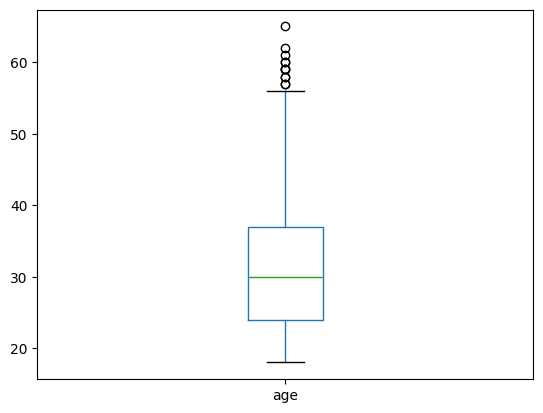

In [11]:
df['age'].plot(kind='box')

In [12]:
df[df['age']>55]['age'].value_counts()

56    5
59    3
57    2
58    2
60    2
65    1
61    1
62    1
Name: age, dtype: int64

**Columna Ingresos**

In [13]:
df['income'].describe()

count     5000.000000
mean     39916.360000
std       9900.083569
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: income, dtype: float64

<AxesSubplot:>

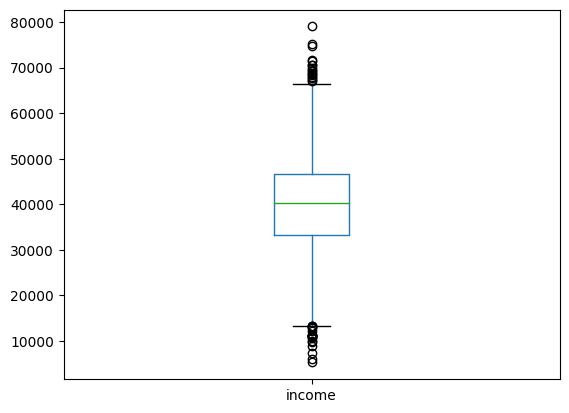

In [14]:
df['income'].plot(kind='box')

**Columna Familiares**

In [15]:
df['family_members'].describe()

count    5000.000000
mean        1.194200
std         1.091387
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: family_members, dtype: float64

<AxesSubplot:>

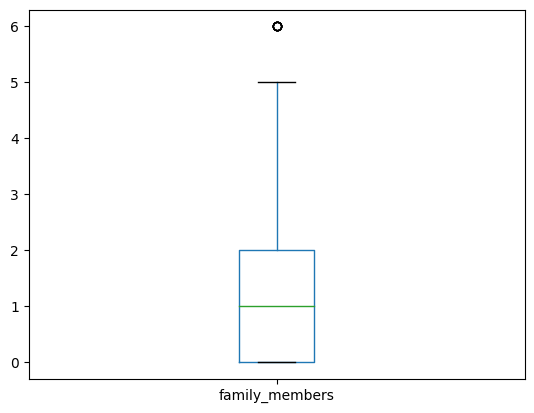

In [16]:
df['family_members'].plot(kind='box')

In [17]:
df['family_members'].value_counts()

1    1814
0    1513
2    1071
3     439
4     124
5      32
6       7
Name: family_members, dtype: int64

Existen diferentes cantidades de valores atípicos para las características: `age` `income` `family_members`. Con mayor cantidad de datos extremos en income.

## Análisis exploratorio de datos

Vamos a comprobar rápidamente si existen determinados grupos de clientes observando el gráfico de pares.

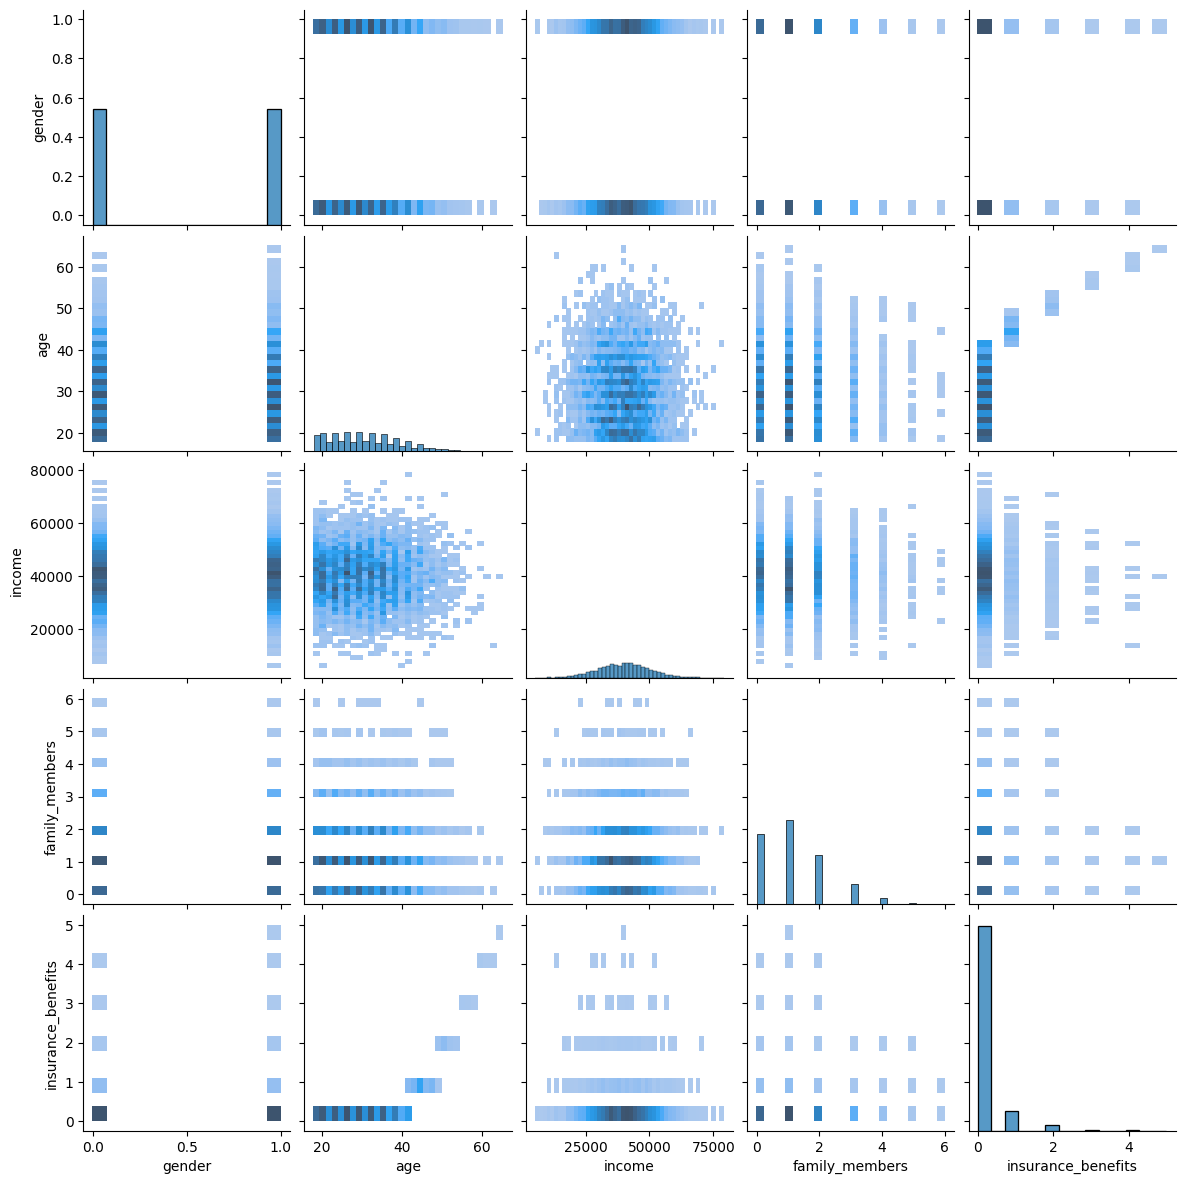

In [18]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

##  Clientes similares

Buscar los k vecinos más cercanos basándose en la distancia entre los objetos.
Para resolver la tarea, podemos probar diferentes métricas de distancia.

Escribir una función que devuelva los k vecinos más cercanos para un $n^{th}$ objeto basándose en una métrica de distancia especificada. Para ello vamos a:

- Escalado con MaxAbsScaler
- Usar métricas de distancia:
  - Euclidiana
  - Manhattan

In [19]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [20]:
def get_knn(df, n, k, metric):
    
    """
    Devuelve los k vecinos más cercanos

    :param df: DataFrame de pandas utilizado para encontrar objetos similares dentro del mismo lugar    :param n: número de objetos para los que se buscan los vecinos más cercanos    :param k: número de vecinos más cercanos a devolver
    :param métrica: nombre de la métrica de distancia    """
    
           
    nbrs = NearestNeighbors(n_neighbors=3, algorithm='auto', metric=metric)
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

Escalar datos.

In [21]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [22]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
2562,1.0,0.430769,0.429114,0.166667,0
799,0.0,0.353846,0.403797,0.166667,0
1863,0.0,0.707692,0.492405,0.166667,1
4583,0.0,0.461538,0.558228,0.500000,0
521,0.0,0.400000,0.487342,0.333333,0


Obtener registros similares para uno determinado, para cada combinación

In [23]:
#Cálculo de 5 vecinos mas cercanos para la observación 500 con distancia euclideana y sin escalar
noscale_eu = get_knn(df,500,5,'euclidean')
noscale_eu

,gender,age,income,family_members,insurance_benefits,distance
500,0,18,54800.0,2,0,0.000000
735,0,18,54800.0,1,0,1.000000
2772,1,19,54800.0,1,0,1.732051
1289,0,21,54800.0,1,0,3.162278
1963,1,24,54800.0,1,0,6.164414


In [24]:
#Cálculo de 5 vecinos mas cercanos para la observación 500 con distancia manhattan y sin escalar
noscale_man = get_knn(df,500,5,'manhattan')
noscale_man

,gender,age,income,family_members,insurance_benefits,distance
500,0,18,54800.0,2,0,0.0
735,0,18,54800.0,1,0,1.0
2772,1,19,54800.0,1,0,3.0
1289,0,21,54800.0,1,0,4.0
1963,1,24,54800.0,1,0,8.0


In [25]:
#Cálculo de 5 vecinos mas cercanos para la observación 500 con distancia euclideana y escalada
scaled_eu = get_knn(df_scaled,500,5,'euclidean')
scaled_eu

,gender,age,income,family_members,insurance_benefits,distance
500,0.0,0.276923,0.693671,0.333333,0,0.000000
3013,0.0,0.292308,0.677215,0.333333,0,0.022527
2705,0.0,0.292308,0.712658,0.333333,0,0.024438
3518,0.0,0.292308,0.665823,0.333333,0,0.031815
2405,0.0,0.292308,0.736709,0.333333,0,0.045705


In [26]:
#Cálculo de 5 vecinos mas cercanos para la observación 500 con distancia manhattan y escalada
scaled_man = get_knn(df_scaled,500,5,'manhattan')
scaled_man

,gender,age,income,family_members,insurance_benefits,distance
500,0.0,0.276923,0.693671,0.333333,0,0.000000
3013,0.0,0.292308,0.677215,0.333333,0,0.031840
2705,0.0,0.292308,0.712658,0.333333,0,0.034372
3518,0.0,0.292308,0.665823,0.333333,0,0.043233
2405,0.0,0.292308,0.736709,0.333333,0,0.058423


**Influencia de escalado en el algoritmo kNN** 

Que los datos no estén escalados si afecta al KNN, pues si observamos los vecinos mas cercanos detectados, vemos que todos tienen el mismo valor de `income`, sin embargo los demás parámetros como `age`, `gender` y `family_members`, no necesariamente tienen los mismos valores que la observación que buscamos clasificar. Esto se puede deber a que al usar distancias, y ser el ingreso la magnitud mas grande, se da prioridad a minimizar la distancia de este parámetro por sobre el resto.

**Similitudes de los resultados al utilizar la métrica de distancia Manhattan (independientemente del escalado)?** 

Las respuestas para el kNN utilizando distancia euclideana y manhattan son muy similares, no existe diferencia en los vecinos seleccionados, solo en los valores de distancia hacia cada vecino.

## Probabilidad de que el cliente reciba una prestación del seguro

Con el valor de `insurance_benefits` superior a cero como objetivo, se evalúa si el enfoque de clasificación kNN puede funcionar mejor que el modelo dummy.

- Se construye un clasificador basado en KNN y se mide su calidad con la métrica F1 para k=1...10 tanto para los datos originales como para los escalados. 
- Se observa cómo k puede influir en la métrica de evaluación y si el escalado de los datos provoca alguna diferencia. 
- Se construye un modelo dummy aleatorio. Debería devolver "1" con cierta probabilidad. Se prueba el modelo con cuatro valores de probabilidad: 0, la probabilidad de pagar cualquier prestación del seguro, 0.5, 1.
La probabilidad de pagar cualquier prestación del seguro puede definirse como
$$
P\{\text{prestación de seguro recibida}\}=\frac{\text{número de clientes que han recibido alguna prestación de seguro}}{\text{número total de clientes}}.
$$

Los datos se dividen correspondientes a las etapas de entrenamiento/prueba respetando la proporción 70:30.

In [27]:
# сalcula el objetivo
df['insurance_benefits_received'] = (df['insurance_benefits']>0).astype(int)

In [ ]:
# desequilibrio de clases con value_counts()
df['insurance_benefits_received'].value_counts()

0    4436
1     564
Name: insurance_benefits_received, dtype: int64

Existe un claro desequilibrio, donde predominan las personas que no han recibido beneficios

In [ ]:
#función que calcula el score f1 y la matriz de confusión
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
        
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Matriz de confusión')
    print(cm)

In [ ]:
# modelo aleatorio
def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [31]:
#Generación de predicción dummy para diferentes probabilidades de recibir beneficios
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'La probabilidad: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P,len(df))    
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

La probabilidad: 0.00
F1: 0.00
Matriz de confusión
[[0.8872 0.    ]
 [0.1128 0.    ]]

La probabilidad: 0.11
F1: 0.12
Matriz de confusión
[[0.7914 0.0958]
 [0.0994 0.0134]]

La probabilidad: 0.50
F1: 0.20
Matriz de confusión
[[0.456  0.4312]
 [0.053  0.0598]]

La probabilidad: 1.00
F1: 0.20
Matriz de confusión
[[0.     0.8872]
 [0.     0.1128]]



El score F1 para todos los escenarios es muy bajo, lo cual indica que el modelo dummy no logra una buena predicción.

In [32]:
# Separación en train y test para paraamtros balanceados y no balanceados
features = df.drop(['insurance_benefits','insurance_benefits_received'],axis=1)
target = df['insurance_benefits_received']
features_train,features_test,target_train,target_test = train_test_split(features,target,test_size=0.3,random_state=123)

features_scaled = df_scaled.drop('insurance_benefits',axis=1)
features_sc_train, features_sc_test = train_test_split(features_scaled,test_size=0.3,random_state=123)


In [33]:
#función NearestNeighbors para predicción con distintos k vecinos y cálculo del score F1 
def knn_model(features_train,features_test,target_train,target_test):
    
    for i in range(1,11):
        model = KNeighborsClassifier(n_neighbors=i, algorithm='auto', metric='euclidean')
        model.fit(features_train,target_train)
        target_pred = model.predict(features_test)
        f1 = sklearn.metrics.f1_score(target_test, target_pred)
        print (f'F1 score {f1:.2f} con {i} vecinos')

**Predicción con Datos Originales**

In [34]:
knn_model(features_train,features_test,target_train,target_test)

F1 score 0.67 con 1 vecinos
F1 score 0.40 con 2 vecinos
F1 score 0.41 con 3 vecinos
F1 score 0.20 con 4 vecinos
F1 score 0.23 con 5 vecinos
F1 score 0.14 con 6 vecinos
F1 score 0.14 con 7 vecinos
F1 score 0.06 con 8 vecinos
F1 score 0.08 con 9 vecinos
F1 score 0.03 con 10 vecinos


**Predicción con Datos Escalados**

In [35]:
knn_model(features_sc_train,features_sc_test,target_train,target_test)

F1 score 0.95 con 1 vecinos
F1 score 0.92 con 2 vecinos
F1 score 0.93 con 3 vecinos
F1 score 0.90 con 4 vecinos
F1 score 0.92 con 5 vecinos
F1 score 0.93 con 6 vecinos
F1 score 0.94 con 7 vecinos
F1 score 0.93 con 8 vecinos
F1 score 0.93 con 9 vecinos
F1 score 0.91 con 10 vecinos


- Tomando en cuenta el score F1, el modelo dummy predice mucho peor que el modelo KNearestNeighbors para clasificar a las personas que han recibido beneficios.
- El número k de vecinos tomados en cuenta para claisifcar a los usuarios influye en el el resultado F1, mostrando que al tomar solo 1 vecino cercano como referencia, el score es mayor, y decrece a medida que aumenta k (solo en datos no escalados).
- El escalado de datos afecta de manera importante en el score F1 y por tanto, en la predicción del modelo de vecinos cercanos, superando el 0.9 para cualquier número k de vecinos.

## Regresión Lineal

Con `insurance_benefits` como objetivo, vamos a evaluar cuál sería la RECM de un modelo de regresión lineal.

Se va a comprobar la RECM tanto para los datos originales como para los escalados.

In [36]:
#Clase Regresión Lineal con matrices
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = ((np.linalg.inv(X2.T @ X2)) @ X2.T) @ y

    def predict(self, X):
        
        # añadir las unidades
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        y_pred = X2 @ self.weights
        
        return y_pred

In [37]:
# función para evaluar el RMSE y el R2 de la predicción 
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

**Datos Originales**

In [38]:
#Aplicación de modelo y cálculo de scores para datos originales
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()
lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-9.43539012e-01  3.57495491e-02  1.64272726e-02 -2.60743659e-07
 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


**Datos Escalados**

In [39]:
#Aplicación de modelo y cálculo de scores para datos escalados
Xsc = df_scaled[feature_names].to_numpy()
X_train, X_test = train_test_split(Xsc,test_size=0.3, random_state=12345)

model = MyLinearRegression()
model.fit(X_train, y_train)
print(model.weights)

y_test_pred = model.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353901  0.01642727  2.32372069 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


Al comparar la predicción del modelo cuando usamos los datos originales versus los datos escalados, vemos que el RSME y el $r²$ son idénticos (no mejora la predicción). Esto se puede deber a que la regresión no depende la magnitud de cada columna, y a que se calcula un vector de pesos adecuado a cada parámetro de entrenamiento.

## Ofuscar datos

Lo mejor es ofuscar los datos multiplicando las características numéricas por una matriz invertible $P$. 

$$
X' = X \times P
$$

In [40]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [41]:
X = df_pn.to_numpy()

Generar una matriz aleatoria $P$.

In [42]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Comprobar que la matriz P sea invertible

In [43]:
#Obtención de matriz identidad
np.round(P.dot(np.linalg.inv(P)))

array([[ 1., -0., -0., -0.],
       [-0.,  1., -0.,  0.],
       [-0., -0.,  1.,  0.],
       [-0., -0.,  0.,  1.]])

Datos de la edad y los ingresos de los clientes después de la transformación

In [44]:
Xof = X.dot(P)
Xof

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

No se puede identificar el valor original de ningún dato númerico

Recuperar los datos originales de $X'$ con $P$

In [45]:
Xrec = np.around(Xof.dot(np.linalg.inv(P)),decimals=1)
Xrec

array([[ 1.00e+00,  4.10e+01,  4.96e+04,  1.00e+00],
       [-0.00e+00,  4.60e+01,  3.80e+04,  1.00e+00],
       [-0.00e+00,  2.90e+01,  2.10e+04,  0.00e+00],
       ...,
       [-0.00e+00,  2.00e+01,  3.39e+04,  2.00e+00],
       [ 1.00e+00,  2.20e+01,  3.27e+04,  3.00e+00],
       [ 1.00e+00,  2.80e+01,  4.06e+04,  1.00e+00]])

Muestra de tres casos para algunos clientes
- Datos originales
- El que está transformado
- El que está invertido (recuperado)

In [46]:
data = pd.DataFrame({'Dato Original':[X[1000,:],X[2000,:],X[3000,:]],
                     'Dato Recuperado':[Xrec[1000,:],Xrec[2000,:],Xrec[3000,:]],
                     'Dato Ofuscado':[Xof[1000,:],Xof[2000,:],Xof[3000,:]]},index=[1000,2000,3000])
data


,Dato Original,Dato Recuperado,Dato Ofuscado
1000,"[1.0, 41.0, 42600.0, 1.0]","[1.0, 41.0, 42600.0, 1.0]","[5462.919844410284, 19227.70311082129, 15828.5..."
2000,"[0.0, 34.0, 29000.0, 2.0]","[-0.0, 34.0, 29000.0, 2.0]","[3719.7851076591714, 13096.008882153637, 10779..."
3000,"[1.0, 32.0, 37100.0, 2.0]","[1.0, 32.0, 37100.0, 2.0]","[4758.0911336838735, 16742.622612844214, 13782..."


No se observan directamente diferencias con los datos originales, pero si se podrían presentar debido a que los cálculos computacionales se ven limitados por la capacidad computacional y pueden haber pequeños errores en los decimales

### Prueba de que la ofuscación de datos puede funcionar con regresión lineal

**Procedimiento**

- Crear una matriz cuadrada $P$ de números aleatorios.
- Comprobar que sea invertible.
- Utilizar $XP$ como la nueva matriz de características

In [47]:
#Generación de matriz P random invertible
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [48]:
#Comprobación de que la matriz P es invertible
inv = np.round(np.linalg.inv(P) @ P)
inv

array([[ 1., -0., -0., -0.],
       [-0.,  1., -0., -0.],
       [-0., -0.,  1.,  0.],
       [-0., -0., -0.,  1.]])

In [49]:
#Matriz ofuscada
XP = X @ P

#Separación, entrenamiento y cálculo de métricas con datos ofuscados
X_train, X_test = train_test_split(XP,test_size=0.3, random_state=12345)

model = MyLinearRegression()
model.fit(X_train, y_train)
print(model.weights)

y_test_pred = model.predict(X_test)
eval_regressor(y_test, y_test_pred)

[-0.94353902 -0.05791721 -0.01546567  0.09871889 -0.02397536]
RMSE: 0.34
R2: 0.66


## Conclusiones

- El escalamiento de los datos ayuda al KNN, puesto que los vecinos mas cercanos detectados, se basan en todas las columnas de características y no solo en el que tiene la magnitud mas grande.
- Las respuestas para el kNN utilizando distancia euclideana y manhattan son muy similares, no existe diferencia en los vecinos seleccionados, solo en los valores de distancia hacia cada vecino.

- El número $k$ de vecinos tomados en cuenta para claisifcar a los usuarios influye en la calidad de predicción, mostrando que al tomar solo 1 vecino, el score es mayor tanto para datos escalados y como no escalados.
- El escalado de datos afecta de manera importante en la predicción del modelo knn, superando el valor $F1=0.9$ para cualquier número $k$ de vecinos. Muy superior al $F1=0.67$ conseguidos con datos originales.

- El ofuscamiento de datos es una técnica muy útil para evitar la filtración de información sensible, para ello hay que tomar en cuenta que la matriz de ofuscación P debe cumplir el principio de ser invertible.
- El ofuscamiento no afecta a la predicción de la regresión lineal ni a las métricas de score como el RMSE o $r²$. En los datos originales (escalados y no escalados) y ofuscados obtuvimos un $RMSE=0.34$ y un $r²=0.66$